In [1]:
import sys, os
sys.path.insert(0, os.path.join("..", ".."))

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.collections
import numpy as np

import open_cp.network
import open_cp.network_hotspot
import open_cp.sources.chicago
import open_cp.geometry

# Geometry reduction

This notebook is some musings on [combinatorial explosion](https://en.wikipedia.org/wiki/Combinatorial_explosion) problems I am having.

A problem we run into is that our graph algorithms are:
- Slow.  Massively not helped by a pure Python implementation
- We end up considering huge numbers of paths.

Let's look more closely at the graphs.  Suppose we "topologically reduce" the graph: delete any vertex which has just two neighbours.  This does not change the search we need to perform when assigning risk, but it does decrease the number of edges and vertices in the graph.  **On second thoughts** this didn't seem to help that much.

In [2]:
with open("Case study Chicago/input.graph", "rb") as f:
    graph = open_cp.network.PlanarGraph.from_bytes(f.read())

In [3]:
reduced = open_cp.network.simple_reduce_graph(graph)

In [4]:
graph.number_edges, reduced.number_edges

(40068, 9771)

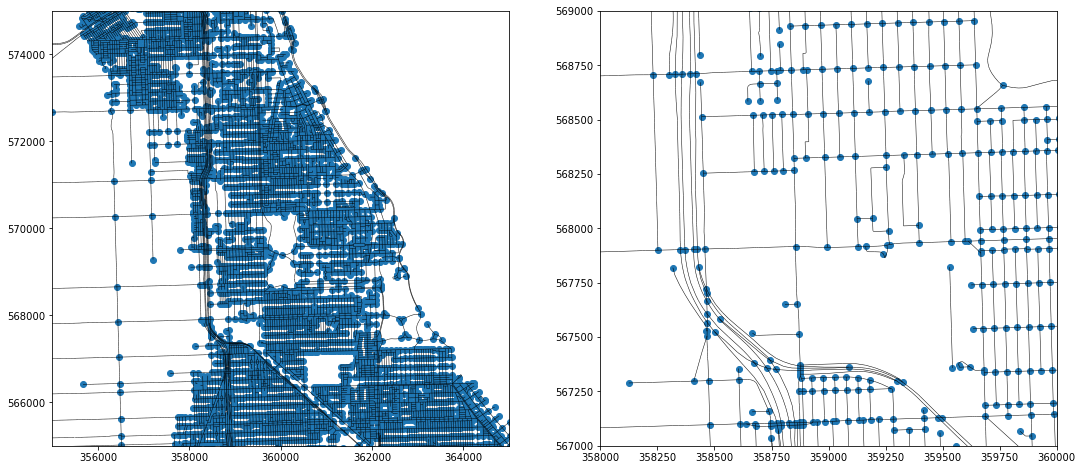

In [5]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))

for ax in axes:
    lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
    ax.add_collection(lc)

xcs, ycs = [], []
for k in reduced.vertices:
    xcs.append(graph.vertices[k][0])
    ycs.append(graph.vertices[k][1])
for ax in axes:
    ax.scatter(xcs, ycs)

axes[0].set(xlim=[355000, 365000], ylim=[565000, 575000])
axes[1].set(xlim=[358000, 360000], ylim=[567000, 569000])
None

# Just too many paths!

The underlying problem seems to be that there is just a combinatorial explosion in the number of paths to consider.

- We find a couple of nearby points in a dense maze of streets and avenues.
- Then find how many paths there are from one starting point, of various lengths.
- This is needed for the KDE algorithm-- there is just an explosion in the number of paths to consider as the maximum length increases.

In [6]:
xmin, xmax = 359000, 359200
ymin, ymax = 568500, 568750
[k for k in reduced.vertices if graph.vertices[k][0] >= xmin and graph.vertices[k][0] <= xmax
    and graph.vertices[k][1] >= ymin and graph.vertices[k][1] <= ymax]

[6743, 7359, 17940, 19461, 23879, 25083, 29222]

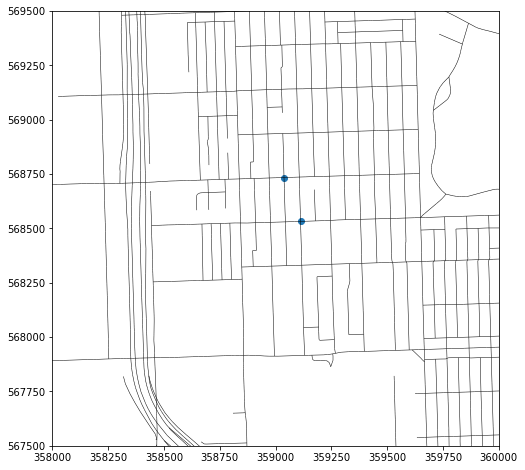

In [7]:
verts = [6743, 17940]

fig, ax = plt.subplots(figsize=(8,8))
lc = matplotlib.collections.LineCollection(graph.as_lines(), color="black", linewidth=0.5)
ax.add_collection(lc)

xcs, ycs = [], []
for k in verts:
    xcs.append(graph.vertices[k][0])
    ycs.append(graph.vertices[k][1])
ax.scatter(xcs, ycs)

ax.set(xlim=[358000, 360000], ylim=[567500, 569500])
None

In [8]:
# Not too many paths between these two vertices...
len(list(graph.paths_between(6743, 17940, 1000)))

43

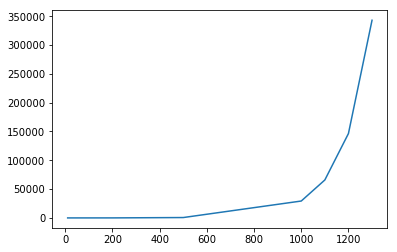

In [9]:
# Explosion in the number of paths to consider for the KDE method...
lengths = [10,20,50,100,200,500,1000,1100,1200,1300]
num_paths = []

for length in lengths:
    nup = len(list(graph.walk_with_degrees(6743, None, length, 10000000000)))
    num_paths.append(nup)
    
plt.plot(lengths, num_paths)

# Some hope

Let's look at an example: pick a nearby edge and see which paths end up crossing it (these are the paths we end up summing in the KDE method to get the final risk estimate).

- We then find that the "cumulative degree" rapidly gets very large
- As we divide by this in the KDE method, we might conjecture that most of these paths are irrelevant.
- This indeed turns out to be the case: most of the summands add very little to the log likelihood.

In [10]:
print(graph.neighbourhood_edges(6743))
print(graph.edges[25201])
print(graph.neighbourhood_edges(13452))

edge = 25202
out = [ path for path in graph.walk_with_degrees(6743, None, 1300, 100000000)
    if path[0] == edge ]
len(out)

[2892, 2893, 25200, 25201]
(6743, 13452)
[25201, 25202]


217

In [11]:
out.sort(key = lambda x : x[3])
out[:5], out[-5:]

([(25202, 41.490110197582254, 68.431643828858185, 3),
  (25202, 472.96907328814666, 499.91060691942261, 54),
  (25202, 475.83059473576679, 502.77212836704274, 81),
  (25202, 608.7669363518105, 635.70846998308639, 324),
  (25202, 606.09726747012235, 633.03880110139824, 486)],
 [(25202, 1281.7162992963026, 1308.6578329275785, 12754584),
  (25202, 1278.4443367161562, 1305.385870347432, 17006112),
  (25202, 1279.0764286403846, 1306.0179622716605, 17006112),
  (25202, 1283.8008086559016, 1310.7423422871775, 19131876),
  (25202, 1281.9082053613611, 1308.849738992637, 19131876)])

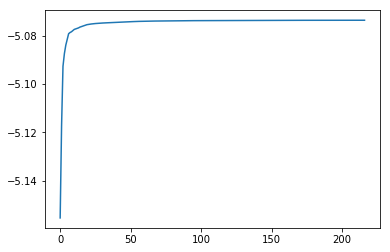

In [12]:
# Example kernel
kernel = open_cp.network_hotspot.TriangleKernel(1500)
out1 = [ kernel.integrate(start, end) / div
    for _, start, end, div in out ]
cumulative_sum = [0]
for x in out1:
    cumulative_sum.append(cumulative_sum[-1] + x)
cumulative_sum = np.asarray(cumulative_sum)
#plt.plot(cummulative_sum)
plt.plot(np.log(cumulative_sum[1:]))

In [13]:
out[25], out[50]

((25202, 1147.6510267824553, 1174.5925604137312, 13122),
 (25202, 1179.5334775598337, 1206.4750111911096, 26244))

# Limiting the maximum degree

If we limit the maximum degree to 20000 then the number of paths to consider begins to tail off, which is hopeful...

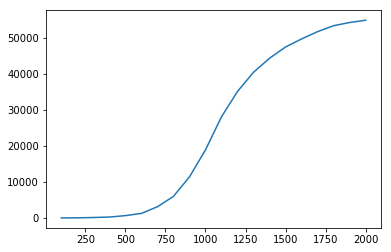

In [27]:
lengths = list(range(100,2100,100))
num_paths = []

for length in lengths:
    nup = len(list(graph.walk_with_degrees(6743, None, length, 20000)))
    num_paths.append(nup)
    
plt.plot(lengths, num_paths)

In [21]:
import pickle, lzma
with lzma.open("Case study Chicago/input.pic.xz", "rb") as f:
    timed_points = pickle.load(f)

trainer = open_cp.network_hotspot.Trainer()
trainer.graph = graph
trainer.maximum_edge_length = 20
trainer.data = timed_points
predictor = trainer.compile()

In [23]:
predictor.graph.number_edges, graph.number_edges

(96168, 40068)

In [25]:
graph.vertices[6743], predictor.graph.vertices[6743]

((359037.44094831066, 568733.8516453756),
 (359037.44094831066, 568733.8516453756))

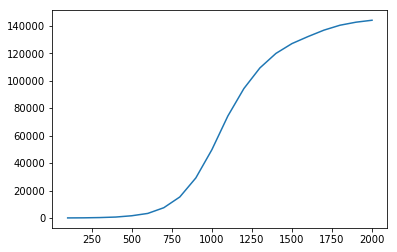

In [26]:
lengths = list(range(100,2100,100))
num_paths = []

for length in lengths:
    nup = len(list(predictor.graph.walk_with_degrees(6743, None, length, 20000)))
    num_paths.append(nup)
    
plt.plot(lengths, num_paths)